In [1]:
#Installing VGG16 convolutional base
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

conv_base.summary()

W0515 16:18:19.449141 139791277479680 deprecation.py:506] From /home/joel/anaconda3/envs/tensorflow-gpu-3-5-2/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


58892288/58889256 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [3]:
#Extracting features using pretrained conv base

import os
import numpy as np
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

base_dir = '/home/joel/Dogs_vs_Cats_Dataset_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size,
                                           class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch #replacing the i * batch_size to (i+1) *
                                                                         #batch_size (4,4,512)-zero arrays 
                                                                         #with the predictions
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch     #same for labels
        i += 1
        if i * batch_size >= sample_count:
            break #break the indefinitely loop after every image has seen once
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [5]:
#Define densely connected classifier with dropout and train it

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30,batch_size=20,
                    validation_data=(validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 356us/sample - loss: 0.6043 - acc: 0.6685 - val_loss: 0.4514 - val_acc: 0.8570
Epoch 2/30
2000/2000 [==============================] - 0s 215us/sample - loss: 0.4307 - acc: 0.7975 - val_loss: 0.3697 - val_acc: 0.8760
Epoch 3/30
2000/2000 [==============================] - 0s 211us/sample - loss: 0.3587 - acc: 0.8530 - val_loss: 0.3290 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 0s 213us/sample - loss: 0.3228 - acc: 0.8635 - val_loss: 0.3066 - val_acc: 0.8790
Epoch 5/30
2000/2000 [==============================] - 0s 214us/sample - loss: 0.3013 - acc: 0.8795 - val_loss: 0.2872 - val_acc: 0.8990
Epoch 6/30
2000/2000 [==============================] - 0s 213us/sample - loss: 0.2700 - acc: 0.8920 - val_loss: 0.2938 - val_acc: 0.8770
Epoch 7/30
2000/2000 [==============================] - 0s 213us/sample - loss: 0.2584 - acc: 0.8965 - val_loss: 0.2707 - va

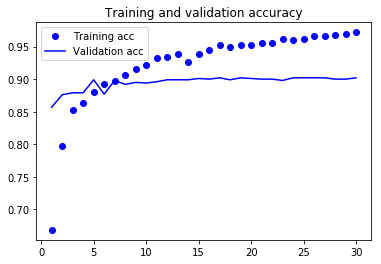

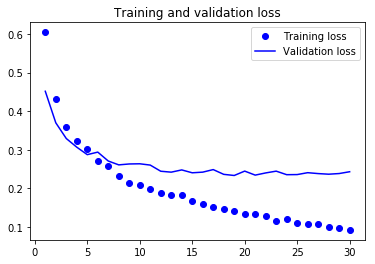

In [7]:
#Plotting test and validation accuracy and loss

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
#Adding the conv_base to a Sequential model for running the inputs
#end-to-end

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
#before compiling and trianing the model, we have to freeze
#the conv base (since we don't want to modify the previous learned
#representation during training)

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable=False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

#The trainable weights are indeed the Weight matrices and the bias vector

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [11]:
#training the model end-to-end with frozen conv-base

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 16s - loss: 0.5890 - acc: 0.7010 - val_loss: 0.4542 - val_acc: 0.8230
Epoch 2/30
100/100 - 15s - loss: 0.4789 - acc: 0.7875 - val_loss: 0.3771 - val_acc: 0.8380
Epoch 3/30
100/100 - 15s - loss: 0.4377 - acc: 0.8025 - val_loss: 0.3436 - val_acc: 0.8580
Epoch 4/30
100/100 - 15s - loss: 0.4016 - acc: 0.8175 - val_loss: 0.3154 - val_acc: 0.8750
Epoch 5/30
100/100 - 15s - loss: 0.3787 - acc: 0.8310 - val_loss: 0.2935 - val_acc: 0.8860
Epoch 6/30
100/100 - 15s - loss: 0.3655 - acc: 0.8455 - val_loss: 0.2834 - val_acc: 0.8800
Epoch 7/30
100/100 - 15s - loss: 0.3609 - acc: 0.8415 - val_loss: 0.2758 - val_acc: 0.8810
Epoch 8/30
100/100 - 15s - loss: 0.3583 - acc: 0.8385 - val_loss: 0.2677 - val_acc: 0.8890
Epoch 9/30
100/100 - 15s - loss: 0.3480 - acc: 0.8455 - val_loss: 0.2633 - val_acc: 0.8940
Epoch 10/30
100/100 - 15s - loss: 0.3369 - acc: 0.8525 - val_loss: 0.2626 - val_acc: 0.8940
Epoch

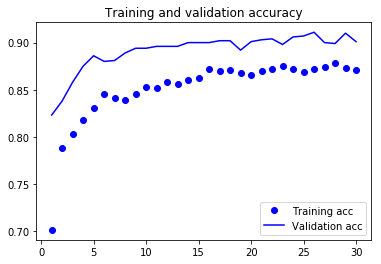

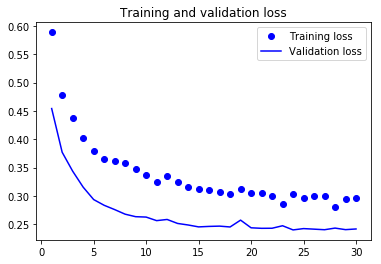

In [14]:
#Plotting the accuracy and loss for the model with frozen conv base and
#data augmentation

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()